GRUPO 17
Investigar el origen del dataset (de dónde proviene, qué mide, en qué contexto se generó).

In [19]:
#Imports usados en todo el tp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
import logging
import statsmodels.api as sm
# URL oficial del dataset
url = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ausa/seguridad-vial-autopistas-ausa/siniestros-2022.csv"

# Leer directamente desde la URL
raw_siniestros = pd.read_csv(url, sep=';', encoding='latin1')

# Verificar carga correcta
siniestros=raw_siniestros
siniestros.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 477 entries, 0 to 476
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   FECHA                       477 non-null    object
 1   HORA                        477 non-null    int64 
 2   AUTOPISTA                   477 non-null    object
 3   BANDA y/o RAMAL             477 non-null    object
 4   PK                          477 non-null    object
 5   CONDICIONES METEOROLÓGICAS  477 non-null    object
 6   SUPERFICIE DE LA VIA        477 non-null    object
 7   LESIONADOS                  477 non-null    int64 
 8   FALLECIDOS                  477 non-null    int64 
 9   TIPO DE SINIESTRO           477 non-null    object
 10  MOTO                        477 non-null    int64 
 11  LVIANO                      477 non-null    int64 
 12  BUS                         477 non-null    int64 
 13  CAMION                      477 non-null    int64 

In [20]:


siniestros = siniestros.replace('-', np.nan)
siniestros.isna().sum()


# Lista exacta de columnas a analizar
columnas = [
    'AUTOPISTA',
    'BANDA y/o RAMAL',
    'PK',
    'CONDICIONES METEOROLÓGICAS',
    'SUPERFICIE DE LA VIA',
    'LESIONADOS',
    'FALLECIDOS',
    'TIPO DE SINIESTRO',
    'MOTO',
    'LVIANO',
    'BUS',
    'CAMION'
]

# Mostrar los valores únicos de cada columna
for col in columnas:
    if col in siniestros.columns:
        print(f"\n--- {col} ---")
        print(siniestros[col].unique())
    else:
        print(f"\n⚠️ La columna '{col}' no se encontró en el DataFrame.")


--- AUTOPISTA ---
['AU 25 DE MAYO' 'AU ILLIA' 'AU FRONDIZI' 'AU PERITO MORENO'
 'AU DELLEPIANE' 'AV. LUGONES' 'TRANSICION RAMAL 1' 'PASEO DEL BAJO'
 'AV. CANTILO' 'AU CAMPORA' 'TRANSICION RAMAL 2' 'DIST. 9 DE JULIO'
 'PTE. SCALABRINI ORTIZ' 'TRANSICION RAMAL 3' 'DIST. DELLEPIANE']

--- BANDA y/o RAMAL ---
['ASCENDENTE' 'DESCENDENTE' 'RAMAL DE EGRESO' 'RAMAL DE ENLACE'
 'DIST. SUR - RAMAL 1' 'RAMAL 2 BIS' nan 'DIST. SUR - RAMAL 2' 'RAMAL 11'
 'RAMAL 3']

--- PK ---
['400' '6400' '2500' '1500' '500' '100' '3800' '3200' '4500' '5200' '3900'
 '4000' nan '5300' '3500' '4200' '3300' '5400' '9000' '6200' '1700' '1200'
 '2300' '4400' '9200' '800' '5500' '1800' '5000' '6100' '10100' '300'
 '5700' '0' '8000' '2000' '2900' '3000' '8800' '1600' '3600' '4700' '3700'
 '3100' '1300' '9800' '7600' '2800' '2100' '9100' '8700' '6500' '8600'
 '6000' '10400' '2400' '1000' '7700' '600' '10000' '2600' '2700' '3400'
 '4600' '7000' '10300' '4800' '1400' '8500' '8100' '2200' '4300' '1900'
 '7900' '200' '8300'

Curado de datos

In [21]:
#casteo PK a INT
siniestros["PK"] = siniestros["PK"].astype("Int64")

Creamos la nueva columna que nos permite ver los vehiculos involucrados en el siniestro y la llamamos "TOTAL_VEHICULOS"

In [22]:
siniestros["TOTAL_VEHICULOS"] = (
    siniestros[["LVIANO", "BUS", "CAMION", "MOTO"]].sum(axis=1)
)

Mostramos el cambio con un head()

In [23]:
siniestros.head()

,FECHA,HORA,AUTOPISTA,BANDA y/o RAMAL,PK,CONDICIONES METEOROLÓGICAS,SUPERFICIE DE LA VIA,LESIONADOS,FALLECIDOS,TIPO DE SINIESTRO,MOTO,LVIANO,BUS,CAMION,TOTAL_VEHICULOS
0,2022-06-01,14,AU 25 DE MAYO,ASCENDENTE,400,BUENO,SECA,0,0,OBSTACULO NO FIJO,1,1,0,0,2
1,2022-06-02,7,AU 25 DE MAYO,ASCENDENTE,6400,BUENO,SECA,1,0,SINIESTRO DE UN SOLO VEHICULO / SIN COLISION,1,0,0,0,1
2,2022-06-02,7,AU ILLIA,ASCENDENTE,2500,BUENO,SECA,0,0,OBSTACULO NO FIJO,0,0,0,1,1
3,2022-06-02,17,AU FRONDIZI,DESCENDENTE,1500,BUENO,SECA,0,0,COLISION CON DOS O MAS VEHICULOS,0,3,0,0,3
4,2022-06-02,17,AU PERITO MORENO,DESCENDENTE,500,BUENO,SECA,1,0,COLISION CON DOS O MAS VEHICULOS,1,0,0,1,2


Acto siguiente, notamos algunas similitudes entre nombres en las autopistas y analizamos si se referian al mismo lugar (por ejemplo AU DELLEPIANE Y DISTRIBUIDORA DELLEPIANE). Luego de una extensa investigación concluimos que no seria lo correcto unificarlo como lo mismo, ya que si bien la autopista Dellepiane es la principal involucrada en la distribuidora Dellepiane, la misma involucra mas autopistas como la 25 de mayo, Cámpora, etc y decidimos mantenerlo como una ubicación especial.


Para la hipotesis de hora pico investigamos sobre que horario se considera pico en las autopistas, encontramos que hora pico son 7 a 11 y de 16 a 20 de lunes a viernes y los fines de semana es de 11 a 15 y de 17 a 21.



Esto nos sirve para el analisis exploratorio para detectar horas mas frecuentes de siniestros por ejemplo que nos sirvan para la elaboracion de hipotesis.

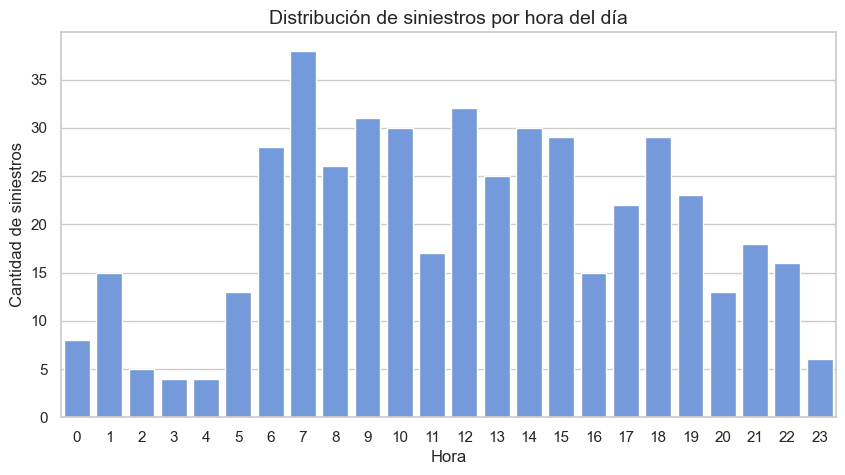

In [24]:


#AHORA VEMOS FRECUENCIA POR HORA
plt.figure(figsize=(10,5))
sns.countplot(data=siniestros, x="HORA", color="cornflowerblue")
plt.title("Distribución de siniestros por hora del día", fontsize=14)
plt.xlabel("Hora")
plt.ylabel("Cantidad de siniestros")
plt.xticks(range(0,24))
plt.show()


Hipotesis 1(HORA PICO):

In [25]:

siniestros["FECHA"] = pd.to_datetime(siniestros["FECHA"], errors="coerce")
# Día de la semana (0=Lunes, 6=Domingo)
siniestros["DIA_SEMANA"] = siniestros["FECHA"].dt.dayofweek
#Definimos si es hora pico o no
def es_hora_pico(hora, dia_semana):
    # Día hábil: lunes (0) a viernes (4)
    if dia_semana in range(0, 5):
        return (7 <= hora < 11) or (16 <= hora < 20)
    # Fin de semana: sábado (5) o domingo (6)
    elif dia_semana in [5, 6]:
        return (11 <= hora < 15) or (17 <= hora < 21)
    else:
        return False
#Utilizamos la funcion de hora pico
siniestros["HORA_PICO"] = siniestros.apply(
    lambda row: "Sí" if es_hora_pico(row["HORA"], row["DIA_SEMANA"]) else "No",
    axis=1
)

--- Frecuencias Observadas ---
Siniestros en Horario Pico ("Sí"): 215
Siniestros en Horario No Pico ("No"): 262

--- Frecuencias Esperadas ---
Siniestros esperados en Horario Pico: 159.00
Siniestros esperados en Horario No Pico: 318.00


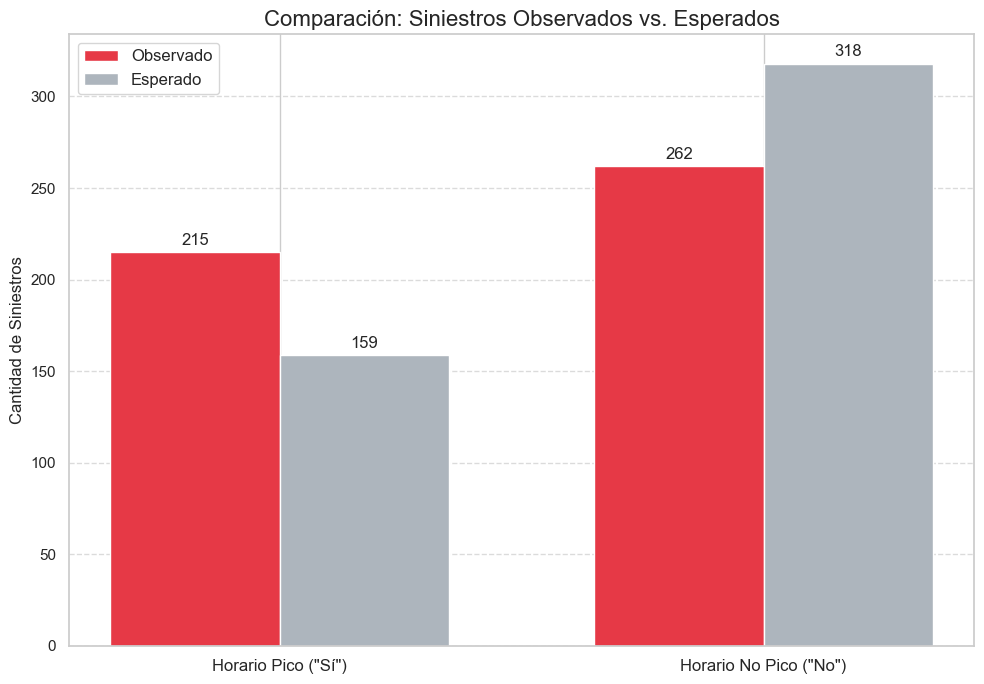

In [26]:
frecuencias_obs = siniestros["HORA_PICO"].value_counts()
O_pico = frecuencias_obs.get("Sí", 0)
O_no_pico = frecuencias_obs.get("No", 0)
N_total_siniestros = O_pico + O_no_pico

print(f"--- Frecuencias Observadas ---")
print(f'Siniestros en Horario Pico ("Sí"): {O_pico}')
print(f'Siniestros en Horario No Pico ("No"): {O_no_pico}')

# Calcular frec esperadas basado en el cálculo que hicimos arriba
P_pico = 56 / 168
P_no_pico = 112 / 168

E_pico = N_total_siniestros * P_pico
E_no_pico = N_total_siniestros * P_no_pico

print(f"\n--- Frecuencias Esperadas ---")
print(f"Siniestros esperados en Horario Pico: {E_pico:.2f}")
print(f"Siniestros esperados en Horario No Pico: {E_no_pico:.2f}")

categorias = ['Horario Pico ("Sí")', 'Horario No Pico ("No")']
valores_observados = [O_pico, O_no_pico]
valores_esperados = [E_pico, E_no_pico]

x = np.arange(len(categorias))
ancho = 0.35  


fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - ancho/2, valores_observados, ancho, label="Observado", color='#E63946') # Rojo
rects2 = ax.bar(x + ancho/2, valores_esperados, ancho, label="Esperado", color='#ADB5BD') # Gris


ax.set_ylabel("Cantidad de Siniestros", fontsize=12)
ax.set_title("Comparación: Siniestros Observados vs. Esperados", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(categorias, fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)


ax.bar_label(rects1, padding=3, fmt='%d')
ax.bar_label(rects2, padding=3, fmt='%.0f') 

fig.tight_layout()
plt.show()

Confirmamos con un test 

In [27]:
f_observadas = [O_pico, O_no_pico]
f_esperadas = [E_pico, E_no_pico]

stat, p_valor = chisquare(f_obs=f_observadas, f_exp=f_esperadas)

print("\nTest Chi-Cuadrado de Bondad de Ajuste")
print(f"Estadístico Chi cuadrado: {stat:.4f}")
print(f"P-valor: {p_valor}") 

alpha = 0.05 
if p_valor < alpha:
    print(f"\nResultado (con α={alpha}): Se rechaza la Hipótesis Nula (p < 0.05)")
    print("La diferencia entre los siniestros observados y los esperados es estadísticamente significativa.")
else:
    print(f"\nResultado (con α={alpha}): No se puede rechazar la Hipótesis Nula. (p >= 0.05)")
    print("La diferencia observada no es estadísticamente significativa.")
    print("No hay evidencia estadística suficiente para afirmar que los siniestros dependen del horario pico.")


Test Chi-Cuadrado de Bondad de Ajuste
Estadístico Chi cuadrado: 29.5849
P-valor: 5.3520098740853275e-08

Resultado (con α=0.05): Se rechaza la Hipótesis Nula (p < 0.05)
La diferencia entre los siniestros observados y los esperados es estadísticamente significativa.


Hipotesis 2(Proporcion de siniestros por banda/ramal):


--- Conteo Total de Siniestros por Banda ---
   Banda_Grupo  Numero_Siniestros
0  Descendente                236
1   Ascendente                222
2        Ramal                 18

--- Conteo Cruzado (Absoluto) por Banda y Tipo ---
Tipo_Siniestro_Grupo  Despiste / Solo Vehículo  \
Banda_Grupo                                      
Ascendente                                  61   
Descendente                                 51   
Ramal                                       15   

Tipo_Siniestro_Grupo  Otros Siniestros (Incl. Colisiones)  
Banda_Grupo                                                
Ascendente                                            161  
Descendente                                           185  
Ramal                                                   3  

--- Proporciones (%) por Banda y Tipo ---
Tipo_Siniestro_Grupo  Despiste / Solo Vehículo  \
Banda_Grupo                                      
Ascendente                           27.477477   
Descendente           

C:\Users\Octavio Collado\AppData\Local\Temp\ipykernel_15940\3176393633.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


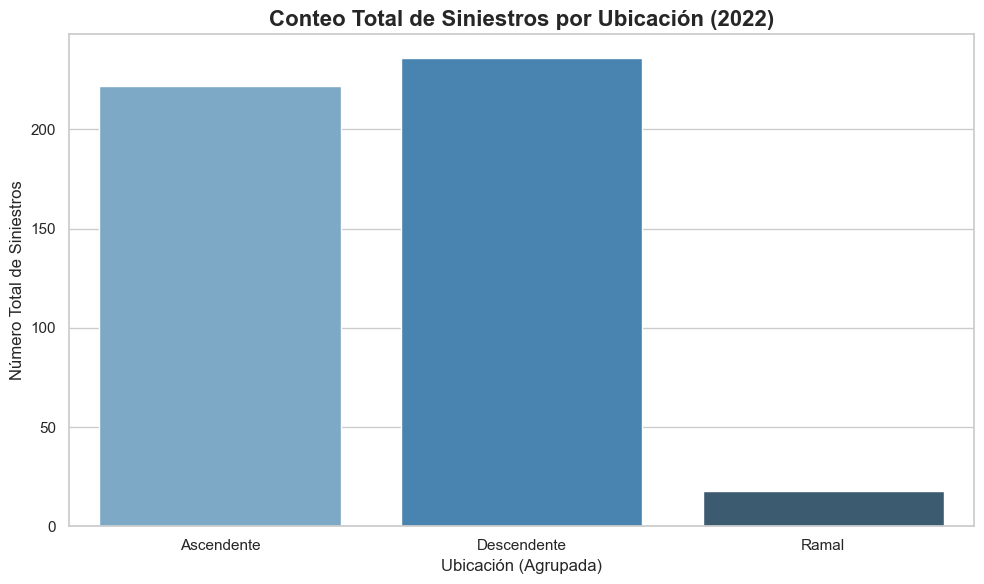

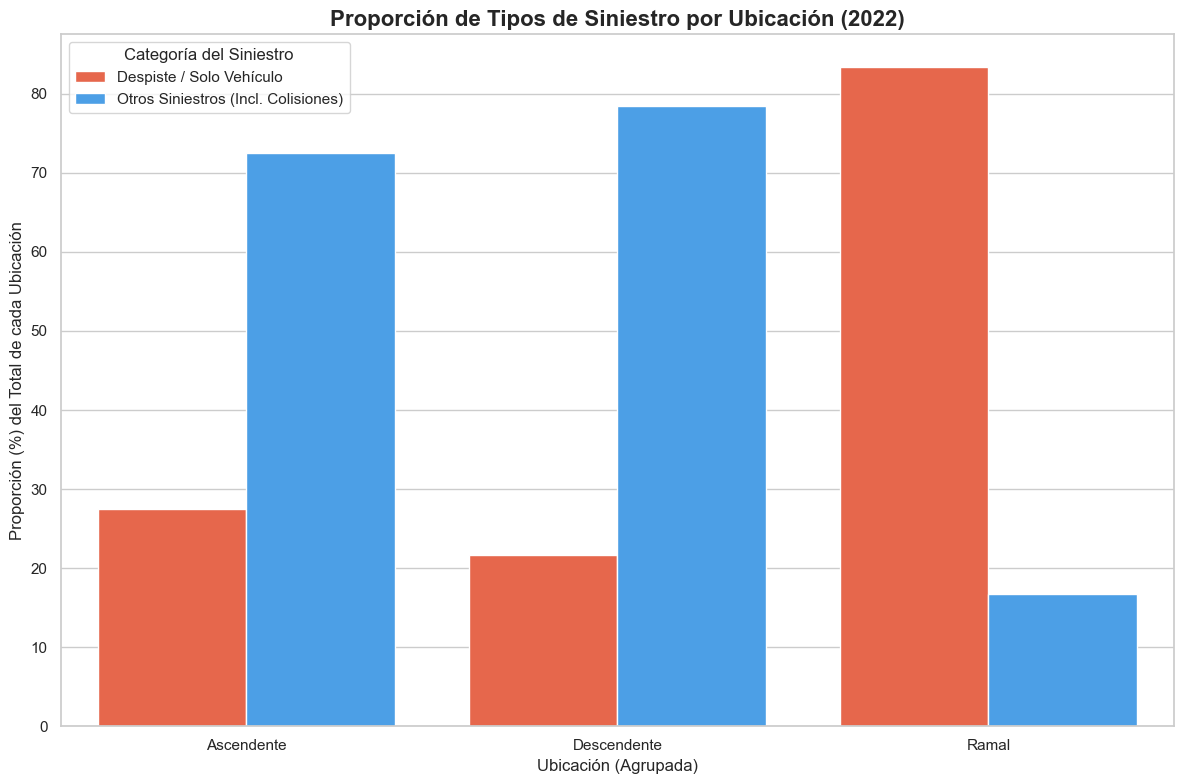

In [28]:

banda_col = "BANDA y/o RAMAL"
tipo_col = "TIPO DE SINIESTRO"

# Clasificar la Banda/Ramal
def clasificar_banda(banda_str):
    """Agrupa las bandas en 'Ascendente', 'Descendente' o 'Ramal'."""
    banda_str = str(banda_str).upper() # Normalizar a mayúsculas
    if "RAMAL" in banda_str:
        return "Ramal"
    if "ASCENDENTE" in banda_str:
        return "Ascendente"
    if "DESCENDENTE" in banda_str:
        return "Descendente"

siniestros["Banda_Grupo"] = siniestros[banda_col].apply(clasificar_banda)

# Filtrar solo los grupos que nos interesan
grupos_interes = ["Ascendente", "Descendente", "Ramal"]
siniestros_filtrado = siniestros[siniestros["Banda_Grupo"].isin(grupos_interes)].copy()

if siniestros_filtrado.empty:
    print("No se encontraron datos para 'Ascendente', 'Descendente' o 'Ramal'. Revisa los valores únicos.")
    exit()

#Clasificar el Tipo de Siniestro
despiste_types = [
    "COLISION CON OBSTACULO FIJO",
    "SINIESTRO DE UN SOLO VEHICULO / SIN COLISION"
]
despiste_types_upper = [s.upper() for s in despiste_types]

def clasificar_siniestro_hipotesis(tipo_str):
    """Clasifica el siniestro en 'Despiste/Solo Vehículo' vs. 'Otros Siniestros'."""
    if str(tipo_str).upper() in despiste_types_upper:
        return "Despiste / Solo Vehículo"
    else:
        return "Otros Siniestros (Incl. Colisiones)"

siniestros_filtrado["Tipo_Siniestro_Grupo"] = siniestros_filtrado[tipo_col].apply(clasificar_siniestro_hipotesis)




# Conteo Absoluto
conteo_total = siniestros_filtrado["Banda_Grupo"].value_counts().reset_index()
conteo_total.columns = ["Banda_Grupo", "Numero_Siniestros"]
print("\n--- Conteo Total de Siniestros por Banda ---")
print(conteo_total)

# Tabla Cruzada de Conteos
conteo_cruzado = pd.crosstab(siniestros_filtrado["Banda_Grupo"], siniestros_filtrado["Tipo_Siniestro_Grupo"])
conteo_cruzado = conteo_cruzado.reindex(grupos_interes)
print("\n--- Conteo Cruzado (Absoluto) por Banda y Tipo ---")
print(conteo_cruzado)

# Calculo de Proporciones
proporciones = pd.crosstab(siniestros_filtrado["Banda_Grupo"], siniestros_filtrado["Tipo_Siniestro_Grupo"], normalize="index") * 100
proporciones = proporciones.reindex(grupos_interes)
print("\n--- Proporciones (%) por Banda y Tipo ---")
print(proporciones)

proporciones_tidy = proporciones.reset_index().melt(id_vars="Banda_Grupo", var_name="Tipo_Siniestro", value_name="Proporcion")



print("\nGenerando gráficos...")
sns.set(style="whitegrid")

# Gráfico 1
plt.figure(figsize=(10, 6))
sns.barplot(
    data=conteo_total,
    x="Banda_Grupo",
    y="Numero_Siniestros",
    order=grupos_interes,
    palette='Blues_d'
)
plt.title('Conteo Total de Siniestros por Ubicación (2022)', fontsize=16, weight='bold')
plt.xlabel('Ubicación (Agrupada)', fontsize=12)
plt.ylabel('Número Total de Siniestros', fontsize=12)
plt.tight_layout()
plt.savefig('conteo_total_siniestros_adaptado.png')
print("Gráfico 'conteo_total_siniestros_adaptado.png' guardado.")


# Gráfico 2
plt.figure(figsize=(12, 8))
sns.barplot(
    data=proporciones_tidy,
    x="Banda_Grupo",
    y="Proporcion",
    hue="Tipo_Siniestro",
    order=grupos_interes,
    palette={'Despiste / Solo Vehículo': '#FF5733', 'Otros Siniestros (Incl. Colisiones)': '#33A1FF'}
)
plt.title('Proporción de Tipos de Siniestro por Ubicación (2022)', fontsize=16, weight='bold')
plt.xlabel('Ubicación (Agrupada)', fontsize=12)
plt.ylabel('Proporción (%) del Total de cada Ubicación', fontsize=12)
plt.legend(title='Categoría del Siniestro', loc='upper left')
plt.tight_layout()
plt.savefig('proporcion_siniestros_por_banda_adaptado.png')

In [29]:

if "conteo_cruzado" in locals() and not conteo_cruzado.empty:
    print("\n\n" + "="*50)
    print("Realizando Test Chi Cuadrado")
    print("="*50)
    
    print("Esta prueba evaluará si existe una asociación entre la 'Ubicación' y el 'Tipo de Siniestro'.")
    print("\nHipótesis Nula (H0): NO hay asociación.")
    print("   -> La proporción de 'Despistes' vs. 'Otros' es la misma en todas las ubicaciones (Bandas y Ramal).")
    print("\nHipótesis Alternativa (H1): SÍ hay asociación.")
    print("   -> La proporción de tipos de siniestro DEPENDE de la ubicación.")
    
    # Pasamos la tabla de contingencia de frecuencias observadas
    try:
        chi2_stat, p_value, dof, expected_freq = chi2_contingency(conteo_cruzado)
        
        print("\nResultados del Test")
        print(f"Estadístico Chi-cuadrado (χ²): {chi2_stat:.4f}")
        print(f"Grados de libertad (dof): {dof}")
        print(f"Valor p (p-value): {p_value}")
        
        print("\nTabla de Frecuencias Esperadas (si H0 fuera cierta):")
        print(pd.DataFrame(expected_freq, 
                           index=conteo_cruzado.index, 
                           columns=conteo_cruzado.columns).round(2))

        print("\nInterpretación")
        alpha = 0.05 
        
        if p_value < alpha:
            print(f"El valor p ({p_value:.6f}) es MENOR que {alpha}.")
            print("Resultado: Se RECHAZA la hipotesis nula (H0).")
            print("Existe una asociación estadísticamente significativa entre la ubicación y el tipo de siniestro.")
        else:
            print(f"El valor p ({p_value:.6f}) es MAYOR que {alpha}.")
            print(" Resultado: NO se puede rechazar la hipótesis nula (H0).")
            print("\nConclusion: No hay evidencia estadística suficiente.")

    except ValueError as e:
        logging.error(f"Error al calcular Chi-Cuadrado: {e}")
        print(f"\nError")
        print(conteo_cruzado)

else:
    print("\nNo se encontro la variable 'conteo_cruzado' o esta vacia.")



Realizando Test Chi Cuadrado
Esta prueba evaluará si existe una asociación entre la 'Ubicación' y el 'Tipo de Siniestro'.

Hipótesis Nula (H0): NO hay asociación.
   -> La proporción de 'Despistes' vs. 'Otros' es la misma en todas las ubicaciones (Bandas y Ramal).

Hipótesis Alternativa (H1): SÍ hay asociación.
   -> La proporción de tipos de siniestro DEPENDE de la ubicación.

Resultados del Test
Estadístico Chi-cuadrado (χ²): 32.7061
Grados de libertad (dof): 2
Valor p (p-value): 7.906122900927879e-08

Tabla de Frecuencias Esperadas (si H0 fuera cierta):
Tipo_Siniestro_Grupo  Despiste / Solo Vehículo  \
Banda_Grupo                                      
Ascendente                               59.23   
Descendente                              62.97   
Ramal                                     4.80   

Tipo_Siniestro_Grupo  Otros Siniestros (Incl. Colisiones)  
Banda_Grupo                                                
Ascendente                                         162.77  
Desc

Hipotesis 3(Media de afectados en siniestros con moto y sin moto):

C:\Users\Octavio Collado\AppData\Local\Temp\ipykernel_15940\2664983223.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=siniestros, x="CON_MOTO", y="AFECTADOS", palette="pastel")


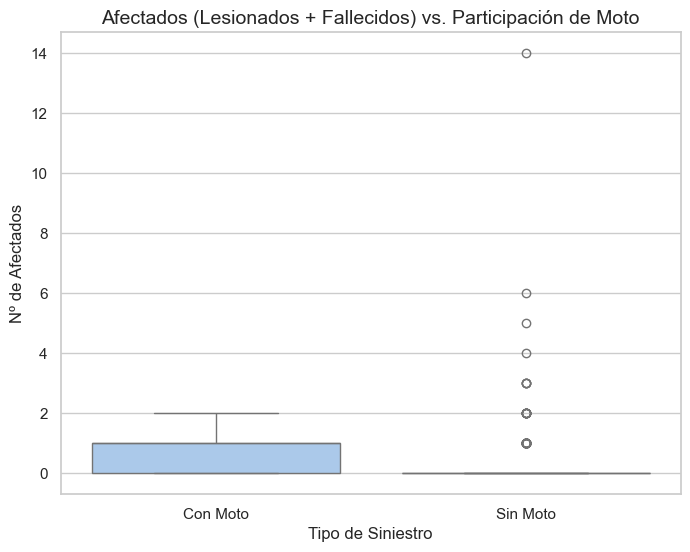

In [30]:
#Crear la columna AFECTADOS
siniestros["AFECTADOS"] = siniestros["LESIONADOS"] + siniestros["FALLECIDOS"]

#  Crear la columna categórica CON MOTO
siniestros["CON_MOTO"] = siniestros["MOTO"].apply(lambda x: "Con Moto" if x > 0 else "Sin Moto")

#grafico
plt.figure(figsize=(8, 6))

sns.boxplot(data=siniestros, x="CON_MOTO", y="AFECTADOS", palette="pastel")


plt.title("Afectados (Lesionados + Fallecidos) vs. Participación de Moto", fontsize=14)
plt.xlabel("Tipo de Siniestro", fontsize=12)
plt.ylabel("Nº de Afectados", fontsize=12)

plt.savefig("afectados_vs_motos_seaborn_boxplot.png")


plt.show()

In [31]:

#Separar los dos grupos para el test
grupo_con_moto = siniestros[siniestros["CON_MOTO"] == "Con Moto"]["AFECTADOS"]
grupo_sin_moto = siniestros[siniestros["CON_MOTO"] == "Sin Moto"]["AFECTADOS"]

#Test U
u_statistic, p_value = stats.mannwhitneyu(
    grupo_con_moto, 
    grupo_sin_moto, 
    alternative="greater"
)

#Imprimir los resultados
print(f"--- Resultados del Test U de Mann-Whitney ---")
print(f"Estadístico U: {u_statistic:.2f}")
print(f"P-Valor (p-value): {p_value}")

alpha = 0.05
if p_value < alpha:
    print("\nConclusión: El p-valor es MENOR que 0.05.")
    print("Se rechaza la Hipótesis Nula. La diferencia es estadísticamente significativa.")
else:
    print("\nConclusión: El p-valor es MAYOR que 0.05.")
    print("No se puede rechazar la Hipótesis Nula.")

--- Resultados del Test U de Mann-Whitney ---
Estadístico U: 38721.00
P-Valor (p-value): 8.008904849448282e-27

Conclusión: El p-valor es MENOR que 0.05.
Se rechaza la Hipótesis Nula. La diferencia es estadísticamente significativa.


Analisis en el informe

Hipotesis 4(Tipo de siniestros en pk calientes/no calientes):

Datos tras limpieza (sin nulos en columnas clave): 459 filas.
Umbral de siniestros para ser 'Hotspot' (>=): 3.0
Total de siniestros en Hotspots: 208
Total de siniestros en No-Hotspots: 251

Tabla de Contingencia (Recuentos Observados)
GRUPO_HOTSPOT                                 Hotspot  No-Hotspot
CARACTERISTICA_AGRUPADA                                          
COLISION CON DOS O MAS VEHICULOS                  128         156
COLISION CON OBSTACULO FIJO                        34          41
OBSTACULO NO FIJO                                  30          30
Otros                                               0           1
SINIESTRO DE UN SOLO VEHICULO / SIN COLISION       16          23

--- Resultados del Test Chi-Cuadrado ---
Estadístico Chi-cuadrado (χ²): 1.66
Grados de libertad (dof): 4
P-Valor: 0.7986

--- Interpretación ---
Resultado No Significativo (p-valor >= 0.05)
Se ACEPTA la hipótesis nula.
Conclusión: No se encontró una asociación significativa entre ser un 'hotspot' y el

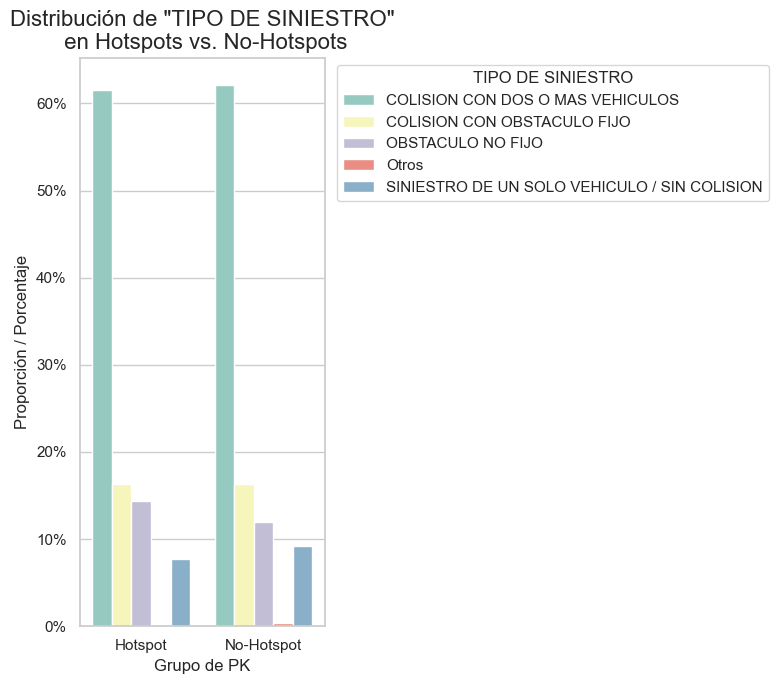

In [32]:

COLUMNA_CARACTERISTICA = "TIPO DE SINIESTRO"
#Umbral de cuantil para definir un hotspot. 0.90 = el 10% de PKS con mas siniestros.
UMBRAL_CUANTIL = 0.90
siniestrosaux=siniestros.copy()
columnas_clave = ["AUTOPISTA", "PK", COLUMNA_CARACTERISTICA]
siniestros_limpios = siniestrosaux.dropna(subset=columnas_clave)
print(f"Datos tras limpieza (sin nulos en columnas clave): {len(siniestros_limpios)} filas.")

pk_counts = (
    siniestros_limpios.groupby(["AUTOPISTA", "PK"])
    .size()
    .reset_index(name="CANTIDAD_SINIESTROS")
)

umbral_siniestros = pk_counts["CANTIDAD_SINIESTROS"].quantile(UMBRAL_CUANTIL)

# Asegurarnos de que el umbral sea al menos 2 (no tiene sentido un hotspot de 1)
if umbral_siniestros < 2:
    print(f"El umbral del cuantil {UMBRAL_CUANTIL} es {umbral_siniestros}, ajustando a un mínimo de 2.")
    umbral_siniestros = 2
else:
    print(f"Umbral de siniestros para ser 'Hotspot' (>=): {umbral_siniestros}")

# Crear la lista de hotspots
pk_counts["ES_HOTSPOT"] = pk_counts["CANTIDAD_SINIESTROS"] >= umbral_siniestros

hotspot_status = pk_counts[["AUTOPISTA", "PK", "ES_HOTSPOT"]]

siniestros_etiquetados = pd.merge(
    siniestros_limpios,
    hotspot_status,
    on=["AUTOPISTA", "PK"],
    how="left"
)

siniestros_etiquetados["GRUPO_HOTSPOT"] = siniestros_etiquetados["ES_HOTSPOT"].map(
    {True: "Hotspot", False: "No-Hotspot"}
)
print(f'Total de siniestros en Hotspots: {siniestros_etiquetados["ES_HOTSPOT"].sum()}')
print(f'Total de siniestros en No-Hotspots: {len(siniestros_etiquetados) - siniestros_etiquetados["ES_HOTSPOT"].sum()}')

#Crear Tabla de Contingencia

conteo_tipos = siniestros_etiquetados[COLUMNA_CARACTERISTICA].value_counts()
tipos_validos = conteo_tipos[conteo_tipos >= 10].index
siniestros_etiquetados["CARACTERISTICA_AGRUPADA"] = np.where(
    siniestros_etiquetados[COLUMNA_CARACTERISTICA].isin(tipos_validos),
    siniestros_etiquetados[COLUMNA_CARACTERISTICA],
    "Otros"
)

tabla_contingencia = pd.crosstab(
    siniestros_etiquetados["CARACTERISTICA_AGRUPADA"],
    siniestros_etiquetados["GRUPO_HOTSPOT"]
)

print("\nTabla de Contingencia (Recuentos Observados)")
print(tabla_contingencia)

#Test chi cuadrado
try:
    chi2, p_valor, dof, frecuencias_esperadas = chi2_contingency(tabla_contingencia)

    print("\n--- Resultados del Test Chi-Cuadrado ---")
    print(f"Estadístico Chi-cuadrado (χ²): {chi2:.2f}")
    print(f"Grados de libertad (dof): {dof}")
    print(f"P-Valor: {p_valor:.4g}")
    print("\n--- Interpretación ---")
    alpha = 0.05 
    if p_valor < alpha:
        print(f"¡Resultado Significativo! (p-valor < {alpha})")
        print(f"Se RECHAZA la hipótesis nula ($H_0$).")
        print(f"Conclusión: Existe una asociación estadísticamente significativa entre ser un 'hotspot' y el '{COLUMNA_CARACTERISTICA}'.")
        print("El 'algo pasa aquí' (tu hipótesis) está respaldado por los datos.")
    else:
        print(f"Resultado No Significativo (p-valor >= {alpha})")
        print(f"Se ACEPTA la hipótesis nula.")
        print(f"Conclusión: No se encontró una asociación significativa entre ser un 'hotspot' y el '{COLUMNA_CARACTERISTICA}'.")

except ValueError as e:
    print(f"\nError al calcular Chi-cuadrado: {e}")
    print("Esto puede pasar si alguna categoría tiene 0 eventos en ambos grupos.")

# Normalizamos la tabla por columna (Hotspot vs No-Hotspot) para ver porcentajes
tabla_porcentual = tabla_contingencia.apply(lambda x: x / x.sum(), axis=0)

data_plot = (tabla_porcentual
             .stack()
             .reset_index()
             .rename(columns={"CARACTERISTICA_AGRUPADA": "Caracteristica", 0: "Porcentaje"}))
# Crear el gráfico
plt.figure(figsize=(10, 7))
sns.barplot(
    data=data_plot,
    x="GRUPO_HOTSPOT",
    y="Porcentaje",
    hue="Caracteristica",
    palette="Set3" 
)

plt.title(f'Distribución de "{COLUMNA_CARACTERISTICA}"\n en Hotspots vs. No-Hotspots', fontsize=16)
plt.ylabel("Proporción / Porcentaje")
plt.xlabel("Grupo de PK")
# Formatear el eje Y como porcentaje
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

# Mover la leyenda fuera del gráfico
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title=COLUMNA_CARACTERISTICA)

plt.tight_layout(rect=[0, 0, 0.8, 1])

# Guardar
plot_filename = "grafico_hotspots_vs_no_hotspots.png"
plt.savefig(plot_filename)
print(f"\nGráfico de barras apilado guardado como: {plot_filename}")

Analisis en informe

Hipotesis 5(Siniestros de madrugada en semana/fin de semana):Los fines de semanas hay mas proporcion de siniestros de madrugada

C:\Users\Octavio Collado\AppData\Local\Temp\ipykernel_15940\164486061.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


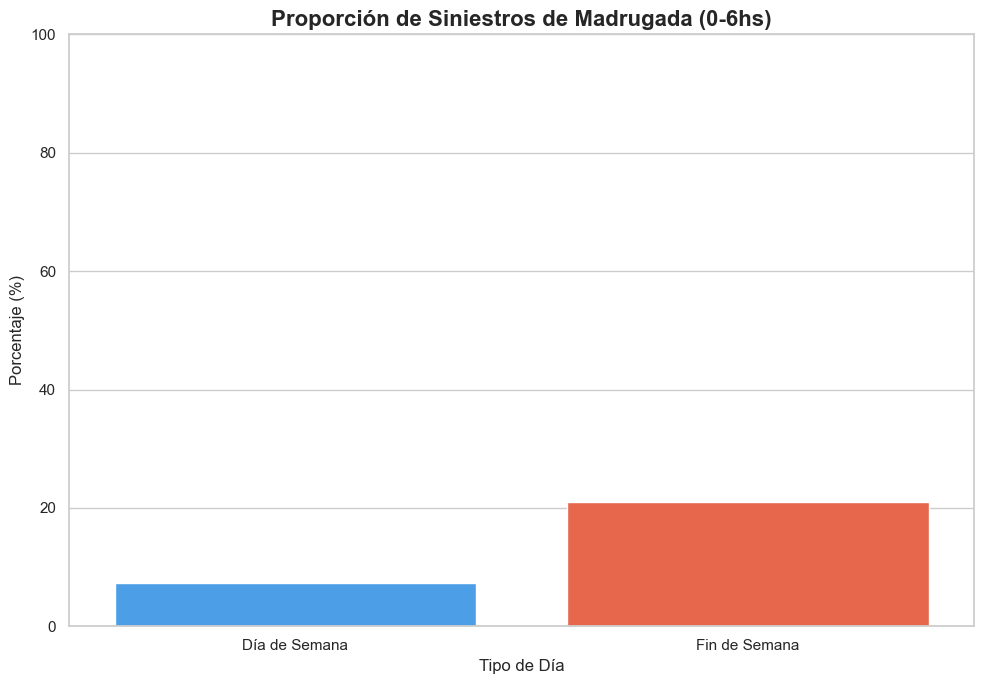

Chi-cuadrado (χ²): 15.208
Grados de libertad: 1
p-valor: 9.629288056355261e-05
Resultado: Se RECHAZA la hipótesis nula (H0).


In [33]:
col_fecha = "FECHA"
col_hora = "HORA"
col_tipo_siniestro = "TIPO DE SINIESTRO"

# Crear franja horaria
siniestros["Hora_Grupo"] = pd.cut(
    siniestros[col_hora],
    bins=[-1, 6, 20, 24],
    labels=["Madrugada (0-6hs)", "Día (7-20hs)", "Noche (21-23hs)"],
    right=False
)


prop_hora = pd.crosstab(
    siniestros["DIA_SEMANA"].isin([5, 6]),
    siniestros["Hora_Grupo"],
    normalize="index"
) * 100

prop_hora = prop_hora.rename(index={False: "Día de Semana", True: "Fin de Semana"})

df_plot1 = prop_hora["Madrugada (0-6hs)"].reset_index()
df_plot1.columns = ["Dia_Tipo", "Porcentaje"]


plt.figure(figsize=(10, 7))
sns.barplot(
    data=df_plot1,
    x="Dia_Tipo",
    y="Porcentaje",
    palette={"Día de Semana": "#33A1FF", "Fin de Semana": "#FF5733"}
)
plt.title("Proporción de Siniestros de Madrugada (0-6hs)", fontsize=16, weight="bold")
plt.xlabel("Tipo de Día")
plt.ylabel("Porcentaje (%)")
plt.ylim(0, 100)
plt.tight_layout()

plt.savefig("grafico_madrugada_semana_vs_finde.png")
plt.show()

# Test chi cuadrado

es_finde = siniestros["DIA_SEMANA"].isin([5, 6])
es_madrugada = siniestros["Hora_Grupo"] == "Madrugada (0-6hs)"

tabla_2x2 = pd.crosstab(es_finde, es_madrugada)

chi2, p_valor, dof, frec_esp = chi2_contingency(tabla_2x2)

print("Chi-cuadrado (χ²):", round(chi2, 4))
print("Grados de libertad:", dof)
print("p-valor:", p_valor)

alpha = 0.05
if p_valor < alpha:
    print("Resultado: Se RECHAZA la hipótesis nula (H0).")
else:
    print("Resultado: NO se rechaza la hipótesis nula (H0).")

Analisis en informe

Hipotesis 6(El numero de afectados en un siniestro esta vinculado a la cantidad de vehículos involucrados y al punto kilometrico donde ocurrio):


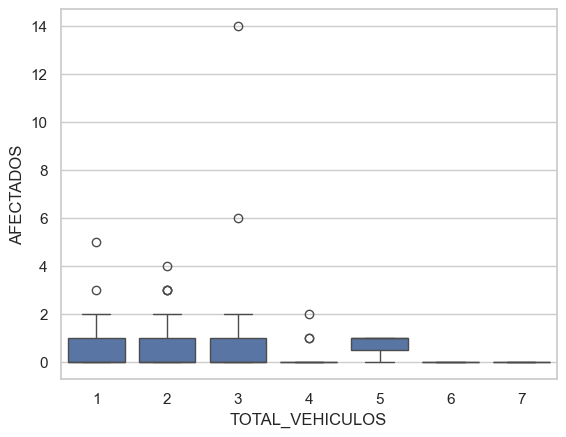

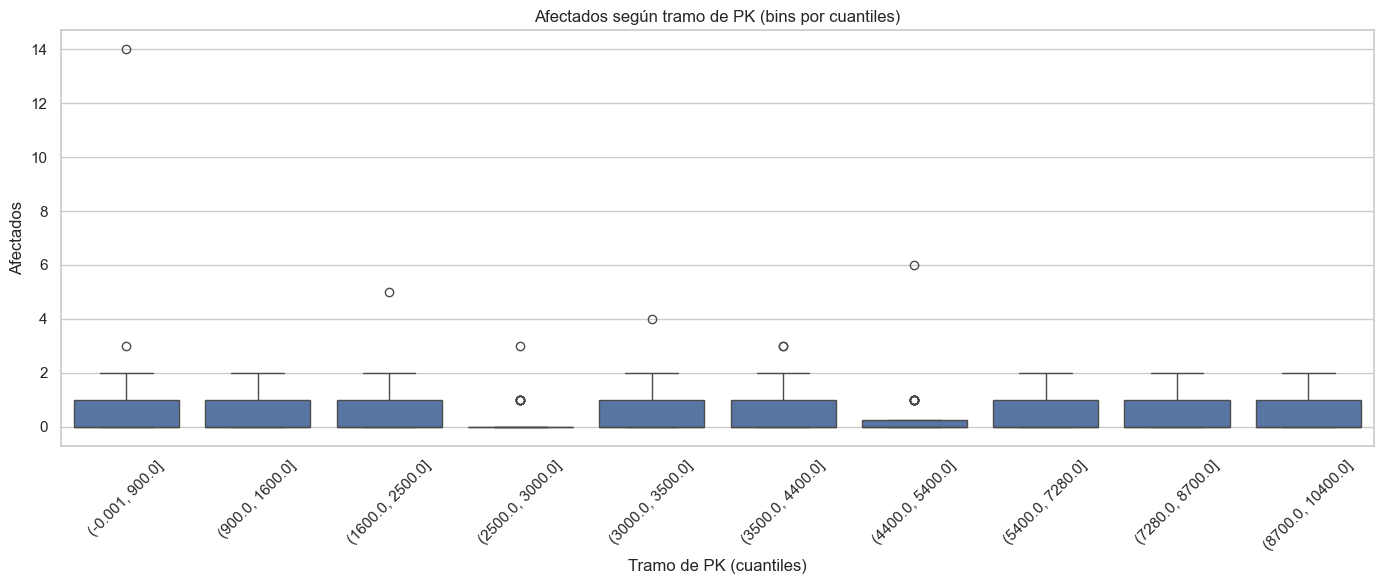

Optimization terminated successfully.
         Current function value: 0.649598
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:          AFECTADOS_BIN   No. Observations:                  459
Model:                          Logit   Df Residuals:                      456
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Nov 2025   Pseudo R-squ.:                0.001476
Time:                        22:03:05   Log-Likelihood:                -298.17
converged:                       True   LL-Null:                       -298.61
Covariance Type:            nonrobust   LLR p-value:                    0.6436
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.3623      0.282     -1.283      0.199      -0.916       0.191
TOTAL_VEHICULO

In [34]:
siniestros["AFECTADOS_BIN"] = (siniestros["AFECTADOS"] > 0).astype(int)

X = siniestros[["TOTAL_VEHICULOS", "PK"]]
y = siniestros["AFECTADOS_BIN"]

mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

X = X.astype(float)
y = y.astype(float)

X = sm.add_constant(X)

sns.boxplot(data=siniestros, x="TOTAL_VEHICULOS", y="AFECTADOS")

#Crear bins de PK por cuantiles
siniestros["PK_BIN"] = pd.qcut(
    siniestros["PK"],
    q=10,              
    duplicates="drop" #para pk repetidos
)

plt.figure(figsize=(14, 6))
sns.boxplot(data=siniestros, x="PK_BIN", y="AFECTADOS")
plt.xticks(rotation=45)
plt.title("Afectados según tramo de PK (bins por cuantiles)")
plt.xlabel("Tramo de PK (cuantiles)")
plt.ylabel("Afectados")
plt.tight_layout()
plt.show()


# 6) Ajustar el modelo logístico
modelo = sm.Logit(y, X).fit()

print(modelo.summary())



